In [9]:
##Estimación de pobreza de vivienda de acuerdo con Evalúa CDMX
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, httr,jsonlite)

In [10]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [20]:
url_hog<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000018/es/07000009/false/BISE/2.0/fe198fe7-c264-840e-c24e-7b28b9af856c?type=json"

In [54]:
hog<-consulta_api(url_hog)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
mutate(obs_value=as.numeric(obs_value))%>%
rename(year=time_period,
hog=obs_value
)%>%
mutate(year=as.numeric(year),
hog=as.numeric(hog))%>%
select(year,hog)%>%
na.omit()%>%
arrange(year)%>%
#Calcular tasas de crecimiento promedio anual
mutate(tcma=100*((hog/lag(hog,1))^(1/5)-1))%>%
#Poner los años que faltan en la tabla
complete(year=2000:2020)%>%
  arrange(year) %>%
  mutate(future_tcma = lead(tcma)) %>%
  fill(future_tcma, .direction = "up") %>%
  mutate(tcma = ifelse(is.na(tcma), future_tcma, tcma)) %>%
  select(-future_tcma)%>%

  # Inicializar la columna de estimación
  mutate(hog_est = hog)

# Estimar valores de hog iterativamente
for (i in 2:nrow(hog)) {
  if (is.na(hog$hog_est[i])) {
    hog$hog_est[i] <- hog$hog_est[i-1] * (1 + hog$tcma[i] / 100)
  }
}

# Final selection and renaming
hog <- hog %>%
  select(year, hog_est) %>%
  rename(hog = hog_est)
hog

year,hog
<dbl>,<dbl>
2000,2180243
2001,2202163
2002,2224303
2003,2246666
2004,2269254
2005,2292069
2006,2311045
2007,2330178
2008,2349470


In [80]:
### Proyecciones de población CONAPO
pob<-read_csv("https://conapo.segob.gob.mx/work/models/CONAPO/Datos_Abiertos/pry23/00_Pob_Mitad_1950_2070.csv",show_col_types = FALSE)%>%
janitor::clean_names()%>%
filter(cve_geo==9)%>%
group_by(ano)%>%
summarise(poblacion=sum(poblacion))%>%
filter(ano<=2045)%>%
rename(year=ano)

pob

year,poblacion
<dbl>,<dbl>
1970,7336320
1971,7509052
1972,7677940
1973,7849693
1974,8022978
1975,8199978
1976,8373187
1977,8537180
1978,8696633


In [112]:
#Pegar tablas para estimar tasas de jefatura

tj<-hog%>%
left_join(pob, by="year")%>%
#Calcular tasas de jefatura
mutate(tj=hog/poblacion)%>%na.omit()
tj

year,hog,poblacion,tj
<dbl>,<dbl>,<dbl>,<dbl>
2000,2180243,8706087,0.2504274
2001,2202163,8758667,0.2514267
2002,2224303,8819709,0.2521969
2003,2246666,8878329,0.2530506
2004,2269254,8931633,0.2540693
2005,2292069,8977190,0.2553214
2006,2311045,9001741,0.2567331
2007,2330178,9011907,0.2585666
2008,2349470,9022695,0.2603956


In [149]:
#Supuesto: tasa de crecimiento promedio anual de tasa de jefatura de 2010 a 2020
tcma_valor<-((tj%>%
filter(year==2020)%>%pull(tj))/(tj%>%
filter(year==2010)%>%pull(tj)))^(1/10)-1
tcma_valor

[1] 0.01124492

In [157]:

tj_final <- tj %>%
  complete(year = 2000:2045) %>%
  arrange(year) %>%

  mutate(tcma_tj = as.numeric(tcma_valor)) %>%
  fill(tcma_tj, .direction = "down") %>%

  mutate(tj_est = tj)

# Estimar valores de tj iterativamente
for (i in 2:nrow(tj_final)) {
  if (is.na(tj_final$tj_est[i])) {
    tj_final$tj_est[i] <- tj_final$tj_est[i-1] * (1 + tj_final$tcma_tj[i])
  }
}


tj_final<-tj_final%>%
select(-poblacion)%>%
left_join(pob, by="year")%>%
mutate(hog=tj_est*poblacion)%>%
#Diferencias de un año a otro de los hogares
mutate(dif_hog=hog-lag(hog,1))%>%
select(year,hog,tj_est,dif_hog)%>%
#Supuesto: hogares censales
rename(viviendas=hog)
tj_final


year,viviendas,tj_est,dif_hog
<dbl>,<dbl>,<dbl>,<dbl>
2000,2180243,0.2504274,NA
2001,2202163,0.2514267,21919.98
2002,2224303,0.2521969,22140.36
2003,2246666,0.2530506,22362.96
2004,2269254,0.2540693,22587.80
2005,2292069,0.2553214,22814.89
2006,2311045,0.2567331,18976.18
2007,2330178,0.2585666,19133.28
2008,2349470,0.2603956,19291.69


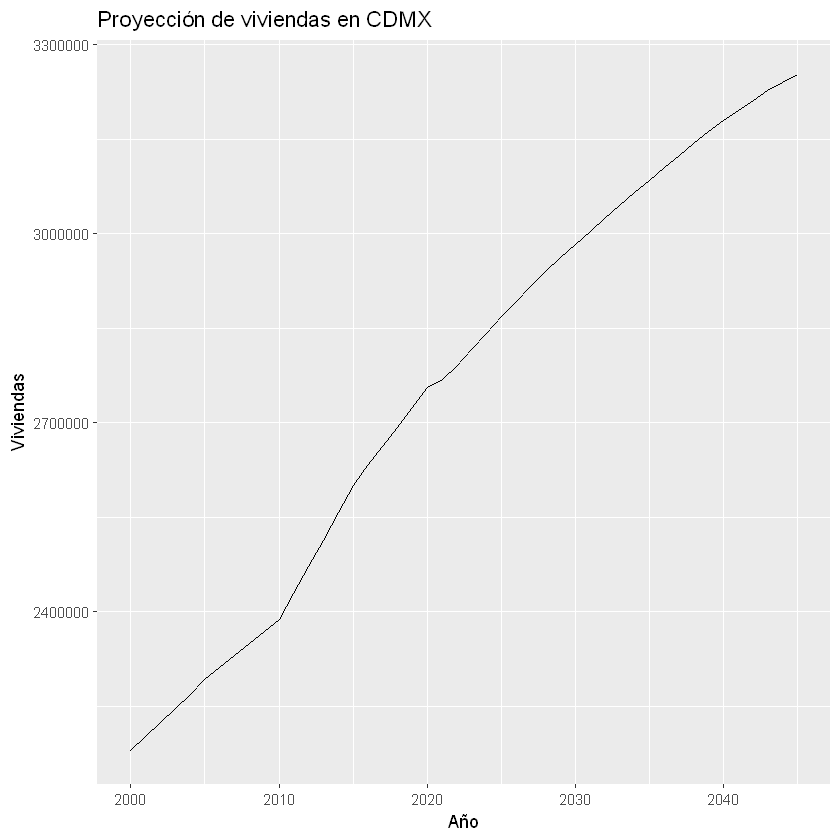

In [162]:
#Graficar hog
tj_final%>%
ggplot(aes(x=year,y=viviendas))+geom_line()+labs(title="Proyección de viviendas en CDMX",x="Año",y="Viviendas")

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


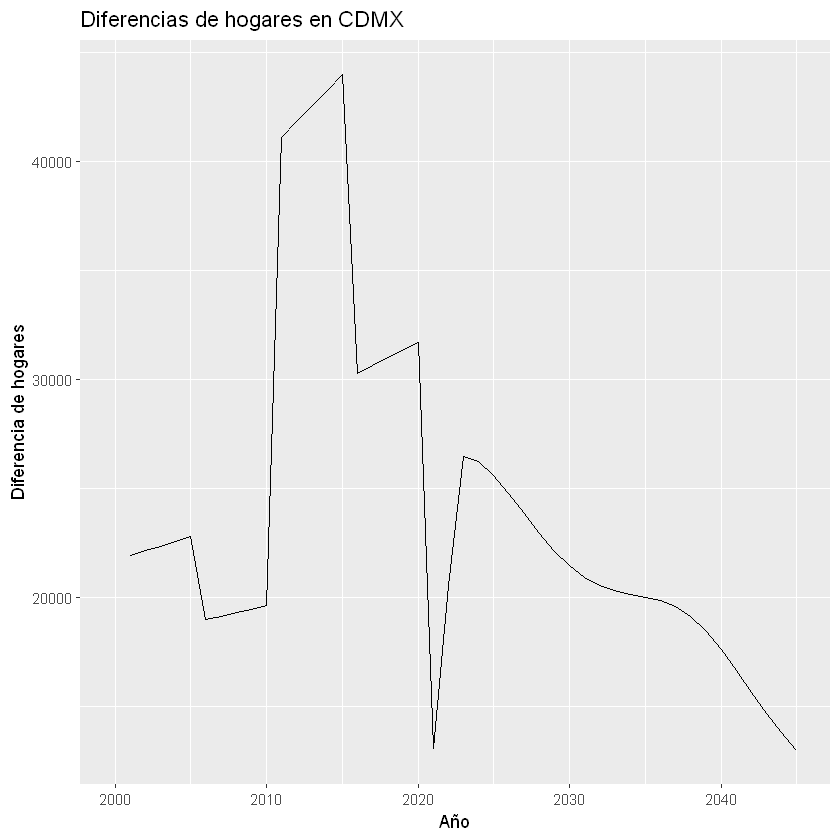

In [163]:
#Graficar diferencias de hogares
tj_final%>%
ggplot(aes(x=year,y=dif_hog))+geom_line()+labs(title="Diferencias de hogares en CDMX",x="Año",y="Diferencia de hogares")